In [1]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn import tree
import networkx as nx
from TreeHelp import Node

# PATH = "/home/erf6575/Desktop/SynthData/"
PATH = os.getcwd() + "/"
SEED = 42

In [2]:
class Dataset:
    
    def __init__(self, filePath):
        
        # Read file
        dataset = pd.read_csv(filePath).dropna()

        # Make sure all values are numeric
        encoder = OrdinalEncoder()
        for col in list(dataset.select_dtypes(include=['object']).columns):
            dataset[col] = encoder.fit_transform(dataset[[col]])

        # Define x and y
        x_input = dataset.drop(columns=['y'])
        y_target = dataset['y']

        X_train, X_test, y_train, y_test = train_test_split(x_input.to_numpy(), y_target.to_numpy(), test_size=0.20, random_state=42, stratify=y_target)
    
        self.x_train = X_train
        self.x_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.x_input = x_input
        self.y_target = y_target
        
    def __repr__(self):
         return f"Dataset <x_train: {self.x_train.shape}, x_test: {self.x_test.shape}, y_train: {self.y_train.shape}, y_test: {self.y_test.shape}>"
        
    def __str__(self):
         return self.__repr__()
        
def print_tree(node, depth=0):
    if node is None:
        return
    # Print the current node with indentation based on its depth
    print(" " * depth * 2 + f"Node(label={node.label}, value={node.value})")
    # Recursively print each child
    for child in node.children:
        print_tree(child, depth + 1)

In [3]:
df_o = Dataset(PATH + "data/iris_original.csv")
df_g = Dataset(PATH + "data/iris_gc.csv")
df_c = Dataset(PATH + "data/iris_ctgan.csv")
df_p = Dataset(PATH + "data/iris_pate.csv")
df_b = Dataset(PATH + "data/iris_pb.csv")


from sklearn.tree import DecisionTreeClassifier

clf_original = DecisionTreeClassifier(random_state=42)
clf_original.fit(df_o.x_train, df_o.y_train)

clf_gc = DecisionTreeClassifier(random_state=42)
clf_gc.fit(df_g.x_train, df_g.y_train)

clf_ctgan = DecisionTreeClassifier(random_state=42)
clf_ctgan.fit(df_c.x_train, df_c.y_train)

clf_pate = DecisionTreeClassifier(random_state=42)
clf_pate.fit(df_p.x_train, df_p.y_train)

clf_pb = DecisionTreeClassifier(random_state=42)
clf_pb.fit(df_b.x_train, df_b.y_train)


from sklearn.metrics import f1_score

print("Orginial F1:", f1_score(df_o.y_test, clf_original.predict(df_o.x_test), average='weighted'))
print("GC F1:", f1_score(df_g.y_test, clf_gc.predict(df_g.x_test), average='weighted'))
print("CTGAN F1:", f1_score(df_c.y_test, clf_ctgan.predict(df_c.x_test), average='weighted'))
print("PATE F1:", f1_score(df_p.y_test, clf_pate.predict(df_p.x_test), average='weighted'))
print("PB F1:", f1_score(df_b.y_test, clf_pb.predict(df_b.x_test), average='weighted'))

Orginial F1: 0.9333333333333333
GC F1: 0.532063492063492
CTGAN F1: 0.3009090909090909
PATE F1: 0.7282913165266105
PB F1: 0.24055555555555555


In [30]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

# Return predictions
Y_pred = clf_original.predict(df_o.x_test)

# Evaluation
acc = accuracy_score(df_o.y_test, Y_pred)
print("Accuracy", acc)
f1 = f1_score(df_o.y_test, Y_pred, average='weighted')
print("F1:", f1)

if len(clf_original.classes_) == 2:
    Y_pred_prob = clf_original.predict_proba(df_o.x_test)[:, 1]
    auc = roc_auc_score(df_o.y_test, Y_pred_prob, average='weighted')
elif len(clf_original.classes_) > 2:
    Y_pred_prob = clf_original.predict_proba(df_o.x_test)
    auc = roc_auc_score(df_o.y_test, Y_pred_prob, average='weighted', multi_class='ovo')
else:
    print("what?")
print("AUC:", auc)

precision = precision_score(df_o.y_test, Y_pred, average='weighted')
print("Precision:", precision)
recall = recall_score(df_o.y_test, Y_pred, average='weighted')
print("Recall:", recall)

Accuracy 0.9333333333333333
F1: 0.9333333333333333
AUC: 0.95
Precision: 0.9333333333333333
Recall: 0.9333333333333333


In [4]:
def build_zss_tree(tree, node_id=0):
    """Helper function to construct tree."""
    if node_id == -1:
        return None
    
    # Check if a leave node
    if tree.feature[node_id] == -2:
        class_label = np.argmax(tree.value[node_id][0])
        node = Node(label=f"Class_{class_label}", value=tree.value[node_id])
    else:
        node = Node(label=tree.feature[node_id], value=tree.value[node_id])
    
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]
    
    if left_child != -1:
        node.addkid(build_zss_tree(tree, left_child))
    if right_child != -1:
        node.addkid(build_zss_tree(tree, right_child))
    
    return node

In [5]:
# def add_nodes_edges(graph, node, parent=None):
#     """Helper function to add nodes and edges to the graph."""
    
#     # Add or update the node
#     if not graph.has_node(node.label):
#         graph.add_node(node.label, label=node.label, value=node.value)
#     else:
#         # Moving average
#         current = graph.nodes[node.label]['value']
#         new = node.value
#         a = np.concatenate((current, new), axis=0)
#         graph.nodes[node.label]['value'] = np.expand_dims(np.mean(a, axis=0), axis=0)
    
#     # Add or update the edge if there is a parent
#     if parent:
#         if not graph.has_edge(parent.label, node.label):
#             graph.add_edge(parent.label, node.label, path=f"[{parent.label}][{node.label}]")
            
        
#     # Recurse  
#     for child in node.children:
#         add_nodes_edges(graph, child, node)

# def tree_to_digraph(root):
#     """Converts a tree to a NetworkX directed graph."""
#     G = nx.DiGraph()
#     add_nodes_edges(G, root)
#     return G

def add_nodes_edges(graph, node, parent=None):
    """Helper function to add nodes and edges to the graph."""
    
    # Add or update the node
    if not graph.has_node(node.label):
        graph.add_node(node.label, label=node.label, value=node.value)
    else:
        # Static average
        current = graph.nodes[node.label]['value']
        new = node.value
        graph.nodes[node.label]['value'] = np.concatenate((current, new), axis=0)
    
    # Add or update the edge if there is a parent
    if parent:
        if not graph.has_edge(parent.label, node.label):
            graph.add_edge(parent.label, node.label, path=f"[{parent.label}][{node.label}]")
            
        
    # Recurse  
    for child in node.children:
        add_nodes_edges(graph, child, node)

def tree_to_digraph(root):
    """Converts a tree to a NetworkX directed graph."""
    G = nx.DiGraph()
    add_nodes_edges(G, root)
    
    # Caculates average at the end
    for node in G.nodes:
        G.nodes[node]['value'] = np.expand_dims(np.mean(G.nodes[node]['value'], axis=0), axis=0)
    return G

In [6]:
tree_original = build_zss_tree(clf_original.tree_)
tree_gc = build_zss_tree(clf_gc.tree_)
tree_ctgan = build_zss_tree(clf_ctgan.tree_)
tree_pate = build_zss_tree(clf_pate.tree_)
tree_pb = build_zss_tree(clf_pb.tree_)

graph_original = tree_to_digraph(tree_original)
graph_gc = tree_to_digraph(tree_gc)
graph_ctgan = tree_to_digraph(tree_ctgan)
graph_pate = tree_to_digraph(tree_pate)
graph_pb = tree_to_digraph(tree_pb)

[Text(0.4, 0.9166666666666666, 'X[2] <= 2.45\ngini = 0.667\nsamples = 120\nvalue = [40, 40, 40]'),
 Text(0.3, 0.75, 'gini = 0.0\nsamples = 40\nvalue = [40, 0, 0]'),
 Text(0.5, 0.75, 'X[3] <= 1.65\ngini = 0.5\nsamples = 80\nvalue = [0, 40, 40]'),
 Text(0.2, 0.5833333333333334, 'X[2] <= 4.95\ngini = 0.133\nsamples = 42\nvalue = [0, 39, 3]'),
 Text(0.1, 0.4166666666666667, 'gini = 0.0\nsamples = 38\nvalue = [0, 38, 0]'),
 Text(0.3, 0.4166666666666667, 'X[0] <= 6.15\ngini = 0.375\nsamples = 4\nvalue = [0, 1, 3]'),
 Text(0.2, 0.25, 'X[1] <= 2.45\ngini = 0.5\nsamples = 2\nvalue = [0, 1, 1]'),
 Text(0.1, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.3, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.4, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]'),
 Text(0.8, 0.5833333333333334, 'X[2] <= 4.85\ngini = 0.051\nsamples = 38\nvalue = [0, 1, 37]'),
 Text(0.7, 0.4166666666666667, 'X[1] <= 3.0\ngini = 0.444\nsamples = 3\nvalue = [0, 1, 2

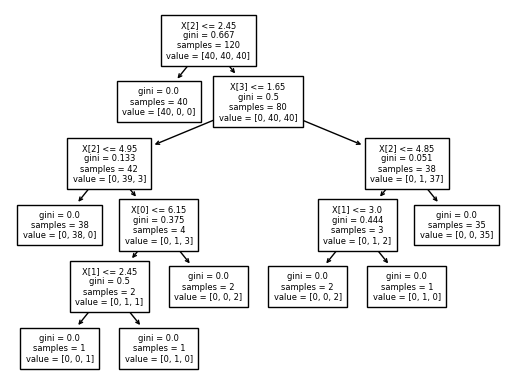

In [7]:
tree.plot_tree(clf_original, fontsize=6)

Node(label=2, value=[[40. 40. 40.]])
  Node(label=Class_0, value=[[40.  0.  0.]])
  Node(label=3, value=[[ 0. 40. 40.]])
    Node(label=2, value=[[ 0. 39.  3.]])
      Node(label=Class_1, value=[[ 0. 38.  0.]])
      Node(label=0, value=[[0. 1. 3.]])
        Node(label=1, value=[[0. 1. 1.]])
          Node(label=Class_2, value=[[0. 0. 1.]])
          Node(label=Class_1, value=[[0. 1. 0.]])
        Node(label=Class_2, value=[[0. 0. 2.]])
    Node(label=2, value=[[ 0.  1. 37.]])
      Node(label=1, value=[[0. 1. 2.]])
        Node(label=Class_2, value=[[0. 0. 2.]])
        Node(label=Class_1, value=[[0. 1. 0.]])
      Node(label=Class_2, value=[[ 0.  0. 35.]])


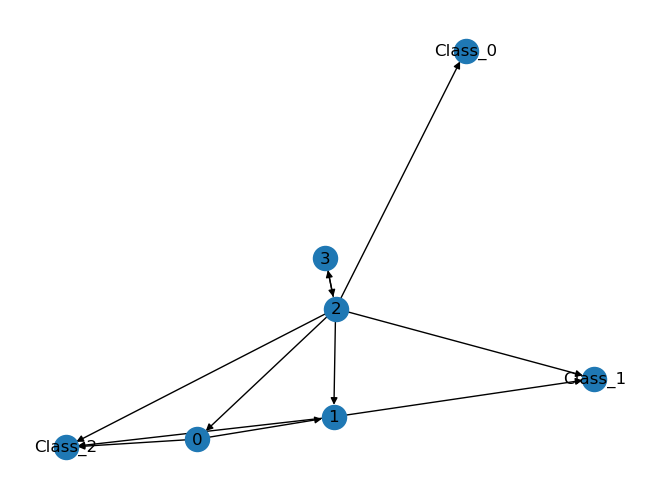

In [8]:
print_tree(tree_original)
nx.draw(graph_original, with_labels=True)

In [9]:
graph_original.nodes[2]

{'label': 2, 'value': array([[13.33333333, 26.66666667, 26.66666667]])}

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def node_subst_cost(u, v):
    
    # Check if same name
    if u['label'] == v['label']:
        
        # Check is same weight
        if np.array_equal(u['value'], v['value']):
            return 0
        else:
            # If similar then cosine_sim == 1, but we want it to be similar, so it's the inverse
            print(u, v)
            return 1 - cosine_similarity(u['value'], v['value'])    
    
    else:
        return 1


print("Original Cost:", nx.graph_edit_distance(graph_original, graph_original, node_subst_cost=node_subst_cost))
print("GC Cost:", nx.graph_edit_distance(graph_original, graph_gc, node_subst_cost=node_subst_cost))
print("CTGAN Cost:", nx.graph_edit_distance(graph_original, graph_ctgan, node_subst_cost=node_subst_cost))
print("PATE Cost:", nx.graph_edit_distance(graph_original, graph_pate, node_subst_cost=node_subst_cost))
print("PB Cost:", nx.graph_edit_distance(graph_original, graph_pb, node_subst_cost=node_subst_cost))

Original Cost: 0.0
{'label': 2, 'value': array([[13.33333333, 26.66666667, 26.66666667]])} {'label': 2, 'value': array([[2.33333333, 3.75      , 1.41666667]])}
{'label': 'Class_0', 'value': array([[40.,  0.,  0.]])} {'label': 'Class_0', 'value': array([[2.27777778, 0.        , 0.        ]])}
{'label': 3, 'value': array([[ 0., 40., 40.]])} {'label': 3, 'value': array([[6.25      , 5.75      , 5.91666667]])}
{'label': 'Class_1', 'value': array([[ 0.        , 13.33333333,  0.        ]])} {'label': 'Class_1', 'value': array([[0.        , 2.06666667, 0.        ]])}
{'label': 0, 'value': array([[0., 1., 3.]])} {'label': 0, 'value': array([[10.9,  6.1,  6.5]])}
{'label': 1, 'value': array([[0. , 1. , 1.5]])} {'label': 1, 'value': array([[5.        , 4.54545455, 8.27272727]])}
{'label': 'Class_2', 'value': array([[ 0.,  0., 10.]])} {'label': 'Class_2', 'value': array([[0.        , 0.        , 3.69230769]])}
GC Cost: 17.837308101319497
{'label': 2, 'value': array([[13.33333333, 26.66666667, 26.

/opt/tljh/user/lib/python3.9/site-packages/networkx/algorithms/similarity.py:1078: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C[0:m, 0:n] = np.array(
/opt/tljh/user/lib/python3.9/site-packages/networkx/algorithms/similarity.py:1078: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C[0:m, 0:n] = np.array(
/opt/tljh/user/lib/python3.9/site-packages/networkx/algorithms/similarity.py:1078: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) 

In [17]:
# The maximum number of operations required to transform one tree into another is determined by the structure and labels of the trees. 
# In the worst-case scenario, you would need to remove all nodes from one tree and then insert all nodes from the other tree. 
# This happens when the two trees have completely different structures and labels.
def count_graph(G):
    return len(G.nodes) + len(G.edges.data())

def count_between(graphA, graphB):
    return count_graph(graphA) + count_graph(graphB)

In [24]:
print("Score:", 1 - nx.graph_edit_distance(graph_original, graph_pate, node_subst_cost=node_subst_cost) / count_between(graph_original, graph_pate) )

{'label': 2, 'value': array([[13.33333333, 26.66666667, 26.66666667]])} {'label': 2, 'value': array([[ 1.33333333, 25.        ,  2.77777778]])}
{'label': 'Class_0', 'value': array([[40.,  0.,  0.]])} {'label': 'Class_0', 'value': array([[1.2, 0. , 0. ]])}
{'label': 3, 'value': array([[ 0., 40., 40.]])} {'label': 3, 'value': array([[ 0.90909091, 25.36363636,  4.        ]])}
{'label': 'Class_1', 'value': array([[ 0.        , 13.33333333,  0.        ]])} {'label': 'Class_1', 'value': array([[0.        , 6.53333333, 0.        ]])}
{'label': 0, 'value': array([[0., 1., 3.]])} {'label': 0, 'value': array([[ 1. , 24.2,  2.8]])}
{'label': 1, 'value': array([[0. , 1. , 1.5]])} {'label': 1, 'value': array([[0.83333333, 8.16666667, 2.83333333]])}
{'label': 'Class_2', 'value': array([[ 0.,  0., 10.]])} {'label': 'Class_2', 'value': array([[0.        , 0.        , 1.33333333]])}
Score: 0.6955372119327247


/opt/tljh/user/lib/python3.9/site-packages/networkx/algorithms/similarity.py:1078: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C[0:m, 0:n] = np.array(
